In [30]:
# !pip install tensorflow

In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras.datasets import imdb

# Load the dataset
(x_train, y_train), (x_test, y_test) = imdb.load_data()

# Combine the train and test data
x_data = np.concatenate((x_train, x_test), axis=0)
y_data = np.concatenate((y_train, y_test), axis=0)

# Get the word index dictionary
word_index = imdb.get_word_index()
word_index = {k: (v + 3) for k, v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2
word_index["<UNUSED>"] = 3
reverse_word_index = {value: key for key, value in word_index.items()}

# Function to decode reviews
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

# Decode all reviews
reviews = [decode_review(review) for review in x_data]

# Create a DataFrame
movie_reviews = pd.DataFrame({'review': reviews, 'sentiment': y_data})

# Display the DataFrame
print(movie_reviews.head())


17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
                                              review  sentiment
0  <START> this film was just brilliant casting l...          1
1  <START> big hair big boobs bad music and a gia...          0
2  <START> this has to be one of the worst films ...          0
3  <START> the scots excel at storytelling the tr...          1
4  <START> worst mistake of my life br br i picke...          0


In [6]:
# movie_reviews = pd.read_csv("IMDB Dataset.csv")
movie_reviews = pd.read_csv("IMDB Dataset.csv", on_bad_lines='skip', engine='python')
movie_reviews.isnull().values.any()

movie_reviews.shape

(50000, 2)

In [5]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from tensorflow.keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer

In [7]:
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [8]:
movie_reviews["review"][3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

In [9]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [10]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [11]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [12]:
X[3]

'Basically there a family where little boy Jake thinks there a zombie in his closet his parents are fighting all the time This movie is slower than soap opera and suddenly Jake decides to become Rambo and kill the zombie OK first of all when you re going to make film you must Decide if its thriller or drama As drama the movie is watchable Parents are divorcing arguing like in real life And then we have Jake with his closet which totally ruins all the film expected to see BOOGEYMAN similar movie and instead watched drama with some meaningless thriller spots out of just for the well playing parents descent dialogs As for the shots with Jake just ignore them '

In [13]:
y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


In [15]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [16]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 256

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [21]:
# ! pip install opendatasets
import opendatasets as od
od.download('https://www.kaggle.com/datasets/incorpes/glove6b200d')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: Michael Nabil
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/incorpes/glove6b200d
Skipping, found downloaded files in "./glove6b200d" (use force=True to force download)


In [23]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove6b200d/glove.6B.200d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [24]:
embedding_matrix = zeros((vocab_size, 200))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [25]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 200, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128,return_sequences=True))
model.add(LSTM(32))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [26]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │      18,509,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,509,400 (70.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 18,509,400 (70.61 MB)

None


In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=16, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/16
250/250 ━━━━━━━━━━━━━━━━━━━━ 332s 1s/step - acc: 0.5342 - loss: 0.6848 - val_acc: 0.5341 - val_loss: 0.6898
Epoch 2/16
250/250 ━━━━━━━━━━━━━━━━━━━━ 377s 1s/step - acc: 0.5368 - loss: 0.6829 - val_acc: 0.5090 - val_loss: 0.6916
Epoch 3/16
250/250 ━━━━━━━━━━━━━━━━━━━━ 380s 1s/step - acc: 0.5284 - loss: 0.6849 - val_acc: 0.5829 - val_loss: 0.6384
Epoch 4/16
250/250 ━━━━━━━━━━━━━━━━━━━━ 323s 1s/step - acc: 0.5561 - loss: 0.6657 - val_acc: 0.5459 - val_loss: 0.7030
Epoch 5/16
250/250 ━━━━━━━━━━━━━━━━━━━━ 384s 1s/step - acc: 0.5592 - loss: 0.6938 - val_acc: 0.5279 - val_loss: 0.6888
Epoch 6/16
250/250 ━━━━━━━━━━━━━━━━━━━━ 388s 1s/step - acc: 0.5296 - loss: 0.6860 - val_acc: 0.6981 - val_loss: 0.6209
Epoch 7/16
250/250 ━━━━━━━━━━━━━━━━━━━━ 378s 1s/step - acc: 0.7814 - loss: 0.4880 - val_acc: 0.8541 - val_loss: 0.3470
Epoch 8/16
250/250 ━━━━━━━━━━━━━━━━━━━━ 324s 1s/step - acc: 0.8464 - loss: 0.3544 - val_acc: 0.8564 - val_loss: 0.3385
Epoch 9/16
250/250 ━━━━━━━━━━━━━━━━━━━━ 382s 1s/

In [28]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.27419668436050415
Test Accuracy: 0.8828999996185303


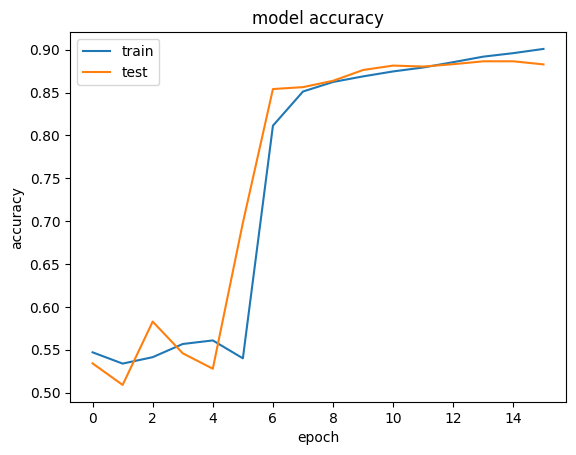

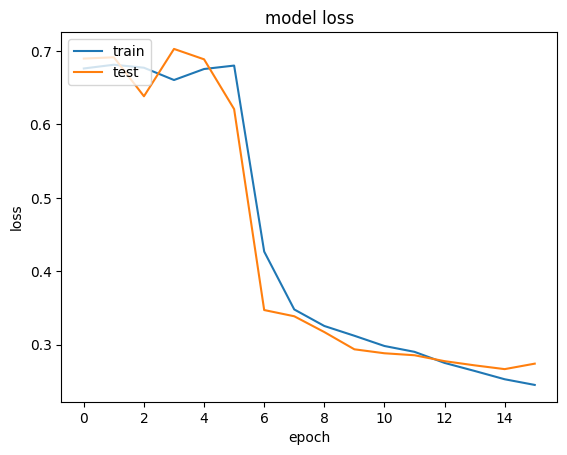

In [29]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
model.save('model-glove.h5')